# Cleaning and Dummification Notebook

This notebook contains all the steps I took to clean my data and make it viable for all types of classificaton algo's.

At the end of this notebook, I load the dataframe into a PostgreSQL database. There isnt really a need for this, but it's a matter of demonstrating the skillset.

In [1]:
%matplotlib inline
import pickle
%run helper_functions.py
pd.options.display.max_columns = 1000
plt.rcParams["figure.figsize"] = (15,10)
from datetime import datetime
# from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = unpickle_object("non_current_df.pkl") #loans that are 'complete'

In [3]:
df.shape

(538008, 110)

I will manipulate my dataset in order for it to be compatible with both GLM's and classification algorithms.

As such, I will create dummies and scale all of data. Scaling is incredibly important for KNN and will improve model performance for Logisitc Regression.

I am not particularly concerned with coeff interpretability as the purpose is the assign a class.

By manipulating my data in this way, I will be ready to be used by any ML model.

I will use 3 in particular:

- Dummy Classifier. This will the global baseline I have to beat.

- KNN (My most constrained model)

- Logistic Regression

- Random Forests

Note that Multi-collinearity does **NOT** matter for models like DT's and RF's - however, it will matter for Logistic regression. I will first throw all of my data at LGR, and remove variables (multi-collinear) accordingly (this creates a baselinne model for lgr).

My project will be concerned with classifying whether an individual will re-pay their loan on time. I will change the 'loan status' feature in this dataset into a binary form of "Fully Paid" or "Late"

In [4]:
df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Late (31-120 days)',
       'Late (16-30 days)', 'In Grace Period', 'Default',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'], dtype=object)

In [5]:
mask = df['loan_status'] != "Fully Paid"
rows_to_change = df[mask]
rows_to_change.loc[:, 'loan_status'] = 'Late'
df.update(rows_to_change)

/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
df['loan_status'].unique() #sweet!

array(['Fully Paid', 'Late'], dtype=object)

In [7]:
df.shape # no dimensionality lost

(538008, 110)

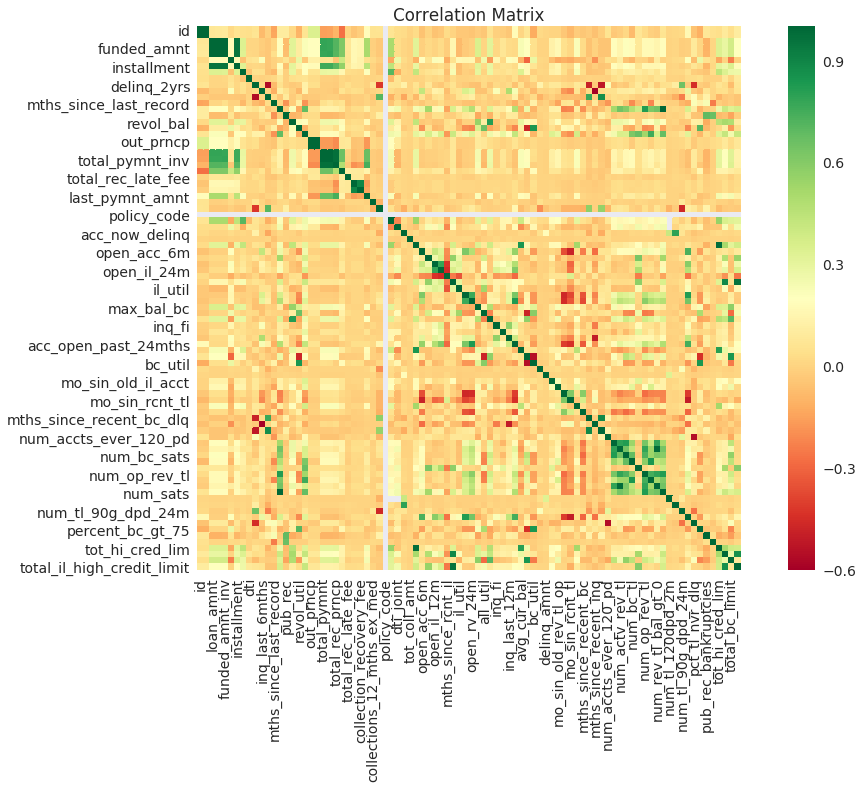

In [8]:
plot_corr_matrix(df)

Let's have a quick look at all of our columns, their descriptions and associated datatype.

Perhaps we can reduce the dimension of our dataset off the bat by dropping columns that are not pertinent

In [9]:
no_desc = []
for column in df.columns:
    try:
        print(column+":",lookup_description(column)," DataType:", df[column].dtype)
        print()
    except KeyError:
        no_desc.append(column)

id: A unique LC assigned ID for the loan listing.  DataType: float64

member_id: A unique LC assigned Id for the borrower member.  DataType: float64

loan_amnt: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.  DataType: float64

funded_amnt: The total amount committed to that loan at that point in time.  DataType: float64

funded_amnt_inv: The total amount committed by investors for that loan at that point in time.  DataType: float64

term: The number of payments on the loan. Values are in months and can be either 36 or 60.  DataType: object

int_rate: Interest Rate on the loan  DataType: float64

installment: The monthly payment owed by the borrower if the loan originates.  DataType: float64

grade: LC assigned loan grade  DataType: object

sub_grade: LC assigned loan subgrade  DataType: object

emp_title: The job title supplied by the Borrower when applying for

In [10]:
columns_to_drop = ["id", "member_id", "emp_title","desc","title","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee","last_pymnt_d", "last_pymnt_amnt","next_pymnt_d", "last_credit_pull_d", "collections_12_mths_ex_med","mths_since_last_major_derog", "all_util", ]

In [11]:
# df.loc[:, ["loan_amnt","funded_amnt","out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","last_credit_pull_d"]]

In [12]:
no_desc

['verification_status_joint', 'total_rev_hi_lim']

In [13]:
df['verification_status_joint'].unique()

array([nan, 'Not Verified', 'Verified', 'Source Verified'], dtype=object)

In [14]:
df['total_rev_hi_lim'].unique()

array([     nan,   29700.,   23800., ...,  334560.,  181280.,   26940.])

In [15]:
df['verification_status_joint'].dtype

dtype('O')

In [16]:
df['total_rev_hi_lim'].dtype

dtype('float64')

After going through the list, I have decided to drop 5 columns!

These will not be relevant to the task at hand. Although, I could use some natural language processig via NLTK to parse job descriptions and loan descriptions. I will leave this for another day.

It is also important to note that I will be dropping variables that hint (i.e. information leakage) at what the final result will be.

In [17]:
df.drop(columns_to_drop, axis=1, inplace=True)

In [18]:
df.shape #just what we expected

(538008, 89)

After reviewing the above, the following columns need to be changed to categorical datatypes from float64.
- policy_code

I will first make it an object datatype as later I will write a function that changed all object datatypes into categorical datatypes.

In [19]:
df["policy_code"] = df["policy_code"].astype('object')

I will have to transform the following columns as they are currently in percentages. I will take the natural log of these columns before proceeding:

- `pct_tl_nvr_dlq`

- `percent_bc_gt_75`

This will ensure better model performance for logistic regression as % may not follow a linear relationship.

In [20]:
df['pct_tl_nvr_dlq'] = df['pct_tl_nvr_dlq'].apply(lambda x: x/100)
df['percent_bc_gt_75'] = df['percent_bc_gt_75'].apply(lambda x: x/100)

My categorical features (those of type Object) have `np.nan` values, I will change these to something more meaningful like "Missing Data".

I will then create dummies for all of my categorical features. This will lead to an explosion in the number of columns - this will be more computationally expensive, however, this is NOT an explosion in the 'feature space' as our dataframe contains the same amount of information.

In [21]:
object_columns = df.select_dtypes(include=['object']).columns

for c in object_columns:
    df.loc[df[df[c].isnull()].index, c] = "missing"

So, our dataset is comprised of features which are categorical and features that are numeric. We need to ensure that the object datatypes are converted to categorical datatypes.

Also, whether we use a GLM or classifier, we need to ensure that these datatypes stay consistent.

NOTE: changing columns to categorical datatypes will NOT change how a machine learning model interprets the data. i.e. The algorithm will still think that 5 > 4. As such, one hot encoding (i.e. making dummies) is the only way to ensure that a Machine Learning Model can detect the presence of a particular attribute.

I will be changing the object datatypes to categorical purely for data consistency within the dataframe.

In [22]:
obj_df = df.select_dtypes(include=['object'])

obj_df_cols = obj_df.columns

for col in obj_df_cols:
    df[col] = df[col].astype("category")
    
df.dtypes.unique() #This is what we wanted!

array([dtype('float64'), category], dtype=object)

In [23]:
df.shape

(538008, 89)

In [24]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,1.0,INDIVIDUAL,NaN,NaN,missing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Late,n,car,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,1.0,INDIVIDUAL,NaN,NaN,missing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,1.0,INDIVIDUAL,NaN,NaN,missing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598.0,21.0,37.0,f,1.0,INDIVIDUAL,NaN,NaN,missing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,1 year,RENT,80000.0,Source Verified,Dec-2011,Fully Paid,n,other,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783.0,53.9,38.0,f,1.0,INDIVIDUAL,NaN,NaN,missing,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [25]:
unique_val_dict = {}
for col in df.columns:
    if col not in unique_val_dict:
        unique_val_dict[col] = df[col].unique()

In [26]:
unique_val_dict #will use this later when making flask app.

{'acc_now_delinq': array([  0.,   1.,  nan,   2.,   3.,   5.,   4.,   6.]),
 'acc_open_past_24mths': array([ nan,   8.,   4.,   6.,   3.,   2.,   0.,   7.,   9.,   1.,   5.,
         10.,  21.,  11.,  12.,  13.,  17.,  14.,  15.,  16.,  18.,  22.,
         19.,  24.,  20.,  28.,  23.,  31.,  25.,  33.,  40.,  27.,  29.,
         26.,  35.,  34.,  47.,  39.,  41.,  32.,  38.,  30.,  37.,  42.,
         53.,  50.,  56.]),
 'addr_state': [AZ, GA, IL, CA, OR, ..., NE, ID, IN, ME, ND]
 Length: 51
 Categories (51, object): [AZ, GA, IL, CA, ..., ID, IN, ME, ND],
 'annual_inc': array([  24000.,   30000.,   12252., ...,  192057.,   53535.,  165840.]),
 'annual_inc_joint': array([       nan,   77000.  ,  113314.  ,  140000.  ,   87000.  ,
         102000.  ,  108000.  ,  182000.  ,  122000.  ,  107000.  ,
         133000.  ,   82000.  ,   95000.  ,   70000.  ,  117000.  ,
         112194.  ,   74000.  ,   83200.  ,  115000.  ,   55000.  ,
         224000.  ,  106000.  ,  185000.  ,   52000.  ,  

In [27]:
category_columns = df.select_dtypes(include=['category']).columns
df = pd.get_dummies(df, columns=category_columns, drop_first=True)

In [28]:
df.shape

(538008, 1926)

Let's ensure that all of our missing values in float columns be nan values via the numpy library. I am doing this because Numpy is a highly optimized library.

In [29]:
float_columns = df.select_dtypes(include=['float64']).columns

for c in float_columns:
    df.loc[df[df[c].isnull()].index, c] = np.nan

In [30]:
pickle_object(unique_val_dict, "unique_values_for_columns")

In [31]:
pickle_object(df, "dummied_dataset")

In [8]:
df = unpickle_object("dummied_dataset.pkl")

In [3]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,term_ 60 months,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year,emp_length_n/a,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,issue_d_Apr-2009,issue_d_Apr-2010,issue_d_Apr-2011,issue_d_Apr-2012,issue_d_Apr-2013,issue_d_Apr-2014,issue_d_Apr-2015,issue_d_Apr-2016,issue_d_Aug-2007,issue_d_Aug-2008,issue_d_Aug-2009,issue_d_Aug-2010,issue_d_Aug-2011,issue_d_Aug-2012,issue_d_Aug-2013,issue_d_Aug-2014,issue_d_Aug-2015,issue_d_Aug-2016,issue_d_Dec-2007,issue_d_Dec-2008,issue_d_Dec-2009,issue_d_Dec-2010,issue_d_Dec-2011,issue_d_Dec-2012,issue_d_Dec-2013,issue_d_Dec-2014,issue_d_Dec-2015,issue_d_Dec-2016,issue_d_Feb-2008,issue_d_Feb-2009,issue_d_Feb-2010,issue_d_Feb-2011,issue_d_Feb-2012,issue_d_Feb-2013,issue_d_Feb-2014,issue_d_Feb-2015,issue_d_Feb-2016,issue_d_Jan-2008,issue_d_Jan-2009,issue_d_Jan-2010,issue_d_Jan-2011,issue_d_Jan-2012,issue_d_Jan-2013,issue_d_Jan-2014,issue_d_Jan-2015,issue_d_Jan-2016,issue_d_Jul-2007,issue_d_Jul-2008,issue_d_Jul-2009,issue_d_Jul-2010,issue_d_Jul-2011,issue_d_Jul-2012,issue_d_Jul-2013,issue_d_Jul-2014,issue_d_Jul-2015,issue_d_Jul-2016,issue_d_Jun-2007,issue_d_Jun-2008,issue_d_Jun-2009,issue_d_Jun-2010,issue_d_Jun-2011,issue_d_Jun-2012,issue_d_Jun-2013,issue_d_Jun-2014,issue_d_Jun-2015,issue_d_Jun-2016,issue_d_Mar-2008,issue_d_Mar-2009,issue_d_Mar-2010,issue_d_Mar-2011,issue_d_Mar-2012,issue_d_Mar-2013,issue_d_Mar-2014,issue_d_Mar-2015,issue_d_Mar-2016,issue_d_May-2008,issue_d_May-2009,issue_d_May-2010,issue_d_May-2011,issue_d_May-2012,issue_d_May-2013,issue_d_May-2014,issue_d_May-2015,issue_d_May-2016,issue_d_Nov-2007,issue_d_Nov-2008,issue_d_Nov-2009,issue_d_Nov-2010,issue_d_Nov-2011,issue_d_Nov-2012,issue_d_Nov-2013,issue_d_Nov-2014,issue_d_Nov-2015,issue_d_Nov-2016,issue_d_Oct-2007,issue_d_Oct-2008,issue_d_Oct-2009,issue_d_Oct-2010,issue_d_Oct-2011,issue_d_Oct-2012,issue_d_Oct-2013,issue_d_Oct-2014,issue_d_Oct-2015,issue_d_Oct-2016,issue_d_Sep-2007,issue_d_Sep-2008,issue_d_Sep-2009,issue_d_Sep-2010,issue_d_Sep-2011,issue_d_Sep-2012,issue_d_Sep-2013,issue_d_Sep-2014,issue_d_Sep-2015,issue_d_Sep-2016,loan_status_Late,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_h